In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, absolute_import, division

In [3]:
import numpy as np
from GomokuBoard import GomokuBoard
from GomokuTools import GomokuTools as gt
from GomokuData import record_game
from NH9x9 import NH9x9
from Heuristics import Heuristics
from HeuristicPolicy import HeuristicGomokuPolicy
import random
import tensorflow as tf

In [4]:
tf.__version__

'1.8.0'

In [5]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2
STYLE_MIXED=2

In [6]:
heuristics = Heuristics(kappa=3.0)

### Experimenting with smaller action spaces
Here we look at the board (states) that all evolve from an initial board. We're going to train on all board snapshots of a series of heuristically played games.

In [7]:
def new_initial_state(heuristics):
    board = GomokuBoard(heuristics, N=15, disp_width=8)
    policy = HeuristicGomokuPolicy(board, 2)
    board.set(H,8).set('G',6).set(G,8).set(F,8).set(H,9).set(H,10)    
    return board, policy

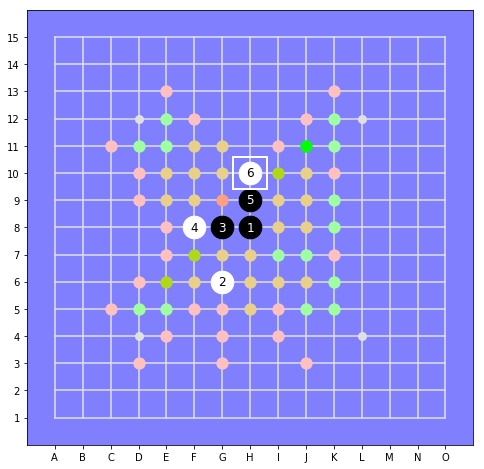

In [8]:
new_initial_state(heuristics)[0].display('current')

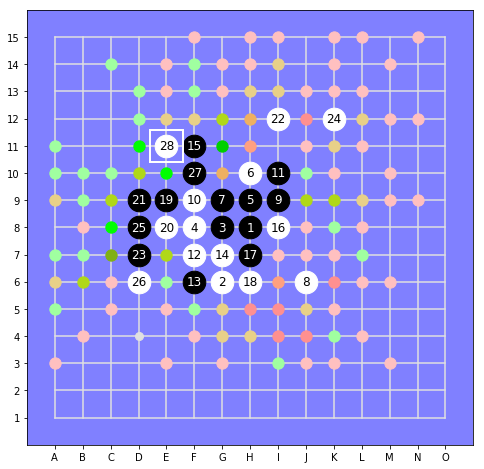

In [9]:
board, policy = new_initial_state(heuristics)
record_game(policy, 30)
board.display('current')

In [10]:
stones = board.stones.copy()

In [11]:
from QFunction import heuristic_QF
from GomokuData import transform, create_sample, wrap_sample

In [12]:
sample = create_sample(board.stones.copy(), board.N, 1-board.current_color)

In [13]:
o,d = np.rollaxis(sample, 2, 0)
2 * d + o

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 1, 2, 2, 1, 1, 2, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 1, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 2, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [14]:
def create_samples_and_qvalues(board, heuristics):
    all_stones_t = [transform(board.stones.copy(), board.N, rot, ref) 
                    for rot in range(4)
                    for ref in [False, True]]

    samples = []
    qvalues = []
    for stones_t in all_stones_t:
        sample = create_sample(stones_t, board.N, 1-board.current_color)
        board = GomokuBoard(heuristics=heuristics, stones=stones_t)
        policy = HeuristicGomokuPolicy(board, STYLE_MIXED)
        qvalue, default_value = heuristic_QF(board, policy)
        qvalue = wrap_sample(qvalue, default_value)
        samples.append(sample)
        qvalues.append(qvalue)

    return np.array(samples), np.reshape(qvalues, [8, board.N+2, board.N+2, 1])

In [15]:
samples, values = create_samples_and_qvalues(board, heuristics)

In [16]:
np.shape(samples),np.shape(values)

((8, 17, 17, 2), (8, 17, 17, 1))

In [17]:
b, w = np.rollaxis(samples[3], 2, 0)
b + 2*w

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 1, 2, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 2, 1, 2, 1, 1, 1, 2, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 2, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, 1, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

### Plausibility check

In [19]:
index = np.argmax(values[3])
r, c = np.divmod(index,17)
pos=gt.m2b((r, c), 17)
print(r,c,pos, values[3][r][c])

11 7 [8 6] [9999.]


In [14]:
from GomokuData import create_samples_and_qvalues

In [15]:
def data_from_game(board, policy, heuristics):    
    """
    Careful: This function rolls back the board
    """
    s,v = create_samples_and_qvalues(board, heuristics)
    while board.cursor > 6:
        board.undo()
        s1, v1 = create_samples_and_qvalues(board, heuristics)
        s = np.concatenate((s,s1))
        v = np.concatenate((v,v1))
    return s,v

In [15]:
from GomokuData import data_from_game

In [21]:
data = data_from_game(board, policy, heuristics)

In [22]:
o,d = np.rollaxis(data[0][30], 2, 0)
2 * d + o

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 2, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 1, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

#### Yet another plausibility check

In [23]:
sample_no = 30
index = np.argmax(data[1][sample_no])
r, c = np.divmod(index,17)
pos=gt.m2b((r, c), 17)
print(r,c,pos)
print("Value of the suggested pos:") 
print(data[1][sample_no][r][c])
print("Value to the right of the suggested pos:") 
print(data[1][sample_no][r][c+1])

4 6 [ 7 13]
Value of the suggested pos:
[-31.53848723]
Value to the right of the suggested pos:
[-9999.]


## Save the results for later training

In [24]:
np.save("samples.npy", data[0])
np.save("values.npy", data[1])

In [25]:
samples = np.load("samples.npy")
values = np.load("values.npy")

In [26]:
samples.shape, values.shape

((176, 17, 17, 2), (176, 17, 17, 1))